# Radar download and quicklook
### from top of our list of tornado events 
#### (wide, close to radar)

In [1]:
import pandas as pd
import numpy as np 
import os
from os import path
from matplotlib.backends.backend_pdf import PdfPages

import datetime
import nexradaws
import pyart 
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
# suppress pink warning boxes (annoying) 
import warnings
warnings.filterwarnings('ignore')

#2222

#http://schumacher.atmos.colostate.edu/resources/archivewx.php
#https://journals.ametsoc.org/view/journals/apme/44/5/jam2235.1.xml


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
filename = '~/Box/MPO624_data/1991-2019_tornadoes_tornadoes.wid>500_byRadarDistances.csv'
wid500 = pd.read_csv(filename)
wid500

,Unnamed: 0,yr,mo,dy,date,time,st,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,NearestRadar,NearestDist
0,0,2015,5,16,5/16/15,22:43:00,OK,2,0,0,1.00,0.0,36.1719,-95.5700,36.2872,-95.4681,9.80,1500,KINX,0.624151
1,1,2019,4,13,4/13/19,22:22:00,MS,2,0,0,500000.00,0.0,33.8931,-88.3215,34.0831,-88.2901,13.20,800,KGWX,0.834936
2,2,2018,4,13,4/13/18,23:10:00,LA,1,0,1,7000000.00,0.0,32.4521,-93.8531,32.6070,-93.5129,22.54,1100,KSHV,1.117873
3,3,2008,4,3,4/3/08,21:06:00,AR,2,0,0,12.00,0.0,34.8100,-92.2700,34.8900,-92.1900,7.07,800,KLZK,3.032709
4,4,2003,4,24,4/24/03,20:53:00,MS,3,6,0,50.00,0.0,32.2500,-90.0000,32.3500,-89.8500,12.00,600,KDGX,3.605939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,1518,2015,5,25,5/25/15,13:42:00,OK,3,1,1,0.00,0.0,33.9830,-96.2684,34.2308,-96.1856,18.80,700,KSRX,227.969035
1519,1519,2011,4,21,4/21/11,17:45:00,TX,2,0,0,0.10,0.0,30.2045,-102.4450,30.1582,-102.3250,7.82,800,KDFX,232.240088
1520,1520,2010,6,17,6/17/10,15:59:00,MN,4,20,0,0.00,0.0,46.4100,-95.1800,46.5216,-95.0260,10.00,1936,KDLH,232.538443
1521,1521,2005,6,6,6/6/05,16:00:00,TX,1,0,0,0.28,0.0,31.4800,-95.4700,31.4800,-95.4700,6.00,850,KPOE,239.073260


# Can we automatically plot a horizontal sweep from the case start time?

The resource:
https://registry.opendata.aws/noaa-nexrad/

A pip package:
https://pypi.org/project/nexradaws/

A notebook that gets a directory listing, but just takes a convenient one
https://github.com/openradar/AMS_radar_in_the_cloud/blob/master/notebooks/introduction%20to%20S3%2C%20Boto%20and%20Nexrad%20on%20S3%20with%20a%20hurricane%20chaser.ipynb 

Something about wildcard-like tools in AWS
https://docs.aws.amazon.com/cli/latest/reference/s3/#use-of-exclude-and-include-filters

Oh bingo, 
https://github.com/openradar/AMS-Open-Source-Radar-2019/blob/master/pyart/3_Pangeo_only_Simple_NEXRAD.ipynb

So much stuff 
https://openradarscience.org/projects/

## To download and plot radar sweeps off Amazon/AWS, 
   * need some environment packages:
   
`conda create -n tropycal -c conda-forge  matplotlib numpy scipy pandas geopy cartopy xarray netCDF4 networkx requests jupyterlab tropycal metpy boto3 botocore boto` and then 
`conda clean —all` frees up disk space from zipped files that went into the environment. From inside the environment, I did `pip install arm_pyart` for the pyart package and `pip install nexradaws` for file access utilities. 

---------------

In [5]:
wid500

,Unnamed: 0,yr,mo,dy,date,time,st,mag,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,NearestRadar,NearestDist
0,0,2015,5,16,5/16/15,22:43:00,OK,2,0,0,1.00,0.0,36.1719,-95.5700,36.2872,-95.4681,9.80,1500,KINX,0.624151
1,1,2019,4,13,4/13/19,22:22:00,MS,2,0,0,500000.00,0.0,33.8931,-88.3215,34.0831,-88.2901,13.20,800,KGWX,0.834936
2,2,2018,4,13,4/13/18,23:10:00,LA,1,0,1,7000000.00,0.0,32.4521,-93.8531,32.6070,-93.5129,22.54,1100,KSHV,1.117873
3,3,2008,4,3,4/3/08,21:06:00,AR,2,0,0,12.00,0.0,34.8100,-92.2700,34.8900,-92.1900,7.07,800,KLZK,3.032709
4,4,2003,4,24,4/24/03,20:53:00,MS,3,6,0,50.00,0.0,32.2500,-90.0000,32.3500,-89.8500,12.00,600,KDGX,3.605939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,1518,2015,5,25,5/25/15,13:42:00,OK,3,1,1,0.00,0.0,33.9830,-96.2684,34.2308,-96.1856,18.80,700,KSRX,227.969035
1519,1519,2011,4,21,4/21/11,17:45:00,TX,2,0,0,0.10,0.0,30.2045,-102.4450,30.1582,-102.3250,7.82,800,KDFX,232.240088
1520,1520,2010,6,17,6/17/10,15:59:00,MN,4,20,0,0.00,0.0,46.4100,-95.1800,46.5216,-95.0260,10.00,1936,KDLH,232.538443
1521,1521,2005,6,6,6/6/05,16:00:00,TX,1,0,0,0.28,0.0,31.4800,-95.4700,31.4800,-95.4700,6.00,850,KPOE,239.073260


--------
# Ready to loop (start with icase=1)

Station: KSRX
Distance from radar(km) 46.38654164730245
KSRX20160324_030056_V06.gz  downloading to 
Downloaded KSRX20160324_030056_V06.gz
1 out of 1 files downloaded...0 errors
Station: KTBW
Distance from radar(km) 46.39908900779611
KTBW20191019_030701_V06  downloading to 
Downloaded KTBW20191019_030701_V06
1 out of 1 files downloaded...0 errors


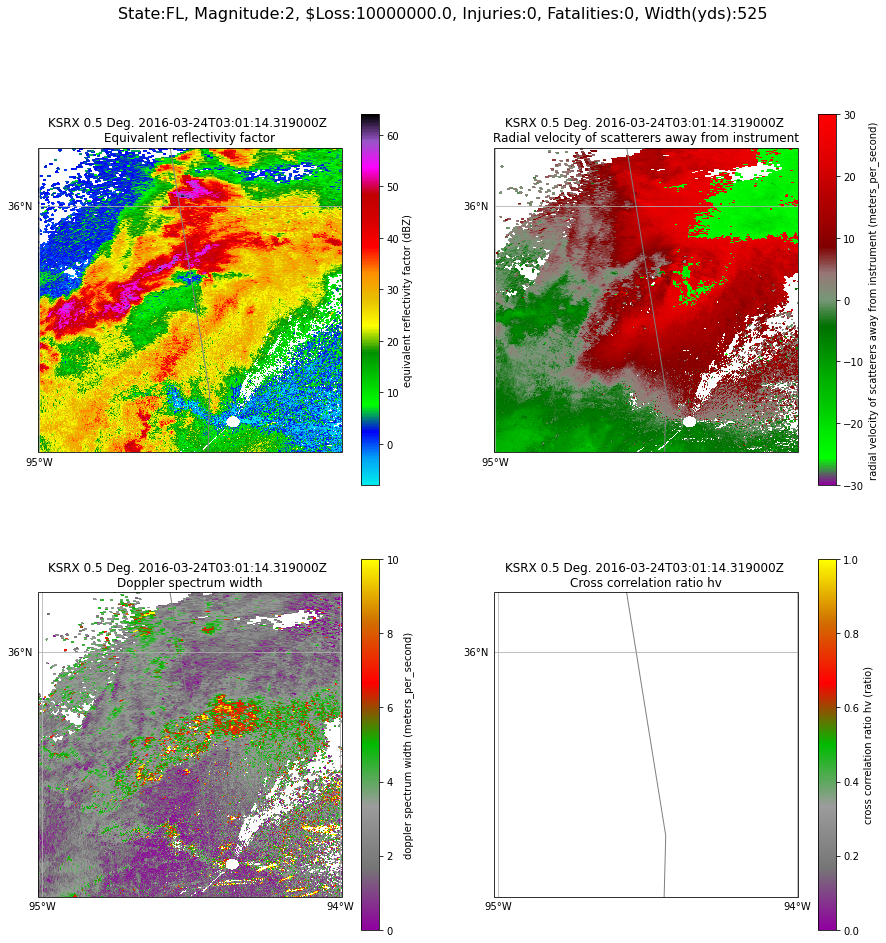

In [14]:
#loop through data, ignoring empty scans



#creat annotation. line segment from slat slong --- elat elon
# color line based 


#1000 - 1025
# PDF 
with PdfPages('/Users/poopiebuttcheeks/Box/MapesGroupUndergradResearch/James/LoopedRadarCaseCollection/Images/test.pdf') as pdf:
     for icase in range(300,302):

            station = wid500['NearestRadar'][icase]
            print("Station:", station)
            distance = wid500['NearestDist'][icase]
            print("Distance from radar(km)", distance)
            
            #super title
            suptitle = fig.suptitle("State:" + str(wid500['st'][icase]) + ", Magnitude:" + str(wid500['mag'][icase]) + ", $Loss:" + str(wid500['loss'][icase]) + ", Injuries:"\
                                  + str(wid500['inj'][icase]) + ", Fatalities:" + str(wid500['fat'][icase]) + ", Width(yds):" + str(wid500['wid'][icase]), fontsize=16)
            
            
            
            #### Where to download the data into: our Box #### 
            data_dir = os.path.expanduser('~/Box/MapesGroupUndergradResearch/NEXRAD_FILES')

            #### Connect to Amazon ####
            conn = nexradaws.NexradAwsInterface()

            # List all scans within 1 hour of the case hour 
            # conn.get_avail_scans_in_range(start, end, radar)


            ####hour and minute formate correction####

            txt= wid500['time'][icase][0:2]
            digits = [txt[i] for i in range(len(txt)) if txt[i].isdigit()]
            hour = int(''.join(digits))

            txt= wid500['time'][icase][3:5]
            digits = [txt[i] for i in range(len(txt)) if txt[i].isdigit()]
            minute = int(''.join(digits))

            ######Convert to datetime---->Central time+6 hours#######

            #d = datetime.datetime(wid500['yr'][icase], wid500['mo'][icase], wid500['dy'][icase],hour)
            d_min = datetime.datetime(wid500['yr'][icase], wid500['mo'][icase], wid500['dy'][icase],hour,minute)
            dcent = d_min+datetime.timedelta(hours=6) #UTC to Central time conversion
            d2 = dcent + datetime.timedelta(hours=1)

            #### Try and obtain avalaib le scan sweeps. If data is empty, ignore ####
            try:
                scans = conn.get_avail_scans_in_range(dcent, d2, wid500['NearestRadar'][icase])
            except:
                print("no scans in range")
                continue

            # next to last sweep in the hour [-2]
            # must avoid filenames not ending in _V06
            # so more code needed here, but this works for icase=1
            try:
                print(scans[1].filename, ' downloading to ')
            except:
                print('ignore error')

            try:
                localfiles = conn.download(scans[1],data_dir)
           

            #print(localfiles.success[0].filepath)

            
                for suc in localfiles.success:
                    fname = (suc.filepath) #/Users/poopiebuttcheeks/Box/MapesGroupUndergradResearch/NEXRAD_FILES/KJAX20080307_140507.gz
                    Datestring = fname[73:88]
                    d_avail= datetime.datetime.strptime(Datestring, "%Y%m%d_%H%M%S")
            
            except:
                print('ignore error')


        #### Plotting ####


            #projection = ccrs.PlateCarree()
            try:
                radar = pyart.io.read(localfiles.success[0].filepath)

                display = pyart.graph.RadarMapDisplay(radar)
            
            except:
                print('ignore error')
           
            projection = ccrs.PlateCarree()

            fig = plt.figure(figsize=[15,15])
            fig.suptitle(suptitle, fontsize=16)

            try:
                ax1 = plt.subplot(221,projection=ccrs.PlateCarree())

                display.plot_ppi_map('reflectivity', 1, vmin=-8, vmax=64, resolution = '10m',\
                             min_lat=wid500.slat[icase]-0.5, max_lat=wid500.slat[icase]+0.5,\
                             min_lon=wid500.slon[icase]-0.5, max_lon=wid500.slon[icase]+0.5,\
                             edges=False,mask_outside = False,cmap = pyart.graph.cm.NWSRef,ax = ax1,projection=ccrs.PlateCarree(),raster = True)
                ax1.arrow(wid500.slat[icase],wid500.slon[icase], wid500.elat[icase], wid500.elon[icase], width=1) 


            except:
                print('ignore error')
            
            try:
                
                ax2 = plt.subplot(222,projection=ccrs.PlateCarree())



                display.plot_ppi_map('velocity', 1, vmin=-30, vmax=30, resolution= '10m',\
                             min_lat=wid500.slat[icase]-0.5, max_lat=wid500.slat[icase]+0.5,\
                             min_lon=wid500.slon[icase]-0.5, max_lon=wid500.slon[icase]+0.5,\
                             cmap = pyart.graph.cm.NWSVel,ax = ax2,projection=ccrs.PlateCarree(),raster = True)
            except:
                print("ignore error")
           
            try:
                
                ax3 = plt.subplot(223,projection=ccrs.PlateCarree())

                display.plot_ppi_map('spectrum_width', 1,vmin = 0, vmax = 10, resolution = '10m',\
                             min_lat=wid500.slat[icase]-0.51, max_lat=wid500.slat[icase]+0.51,\
                             min_lon=wid500.slon[icase]-0.51, max_lon=wid500.slon[icase]+0.51,\
                             cmap = pyart.graph.cm.NWS_SPW,edges=False,mask_outside = False,ax = ax3,projection=ccrs.PlateCarree(),raster = True)
            
            except:
                print('ignore error')
                
            try:
                ax4 = plt.subplot(224,projection=ccrs.PlateCarree())

                display.plot_ppi_map('cross_correlation_ratio', 1,vmin = 0, vmax = 1, resolution = '10m',\
                             min_lat=wid500.slat[icase]-0.51, max_lat=wid500.slat[icase]+0.51,\
                             min_lon=wid500.slon[icase]-0.51, max_lon=wid500.slon[icase]+0.51,\
                             cmap = pyart.graph.cm.NWS_SPW,edges=False,mask_outside = False,ax = ax4,projection=ccrs.PlateCarree(),raster = True)
            except:
                print("No Cross correlation data")


            pdf.savefig(dpi=300)  # saves the current figure into a pdf page
plt.close()

        

# Displays, working off the downloaded data file
### do we want this inside a loop over cases, or outside? 
user chooses, for now it works from the first successfully gotten file of the previous download request 

In [13]:
radar.fields


{'reflectivity': {'units': 'dBZ',
  'standard_name': 'equivalent_reflectivity_factor',
  'long_name': 'Reflectivity',
  'valid_max': 94.5,
  'valid_min': -32.0,
  'coordinates': 'elevation azimuth range',
  '_FillValue': -9999.0,
  'data': masked_array(
    data=[[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]],
    mask=[[ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          ...,
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True]],
    fill_value=1e+20,
    dtype=float32)},
 'spectrum_width': {'units': 'meters_per_second',
  'standard_name': 'd

In [65]:
 #### Plotting ####
outpath = "/Users/poopiebuttcheeks/Box/MapesGroupUndergradResearch/James/LoopedRadarCaseCollection/Images"
fig1.savefig(path.join(outpath,"reflectivity.pdf"))
        
        


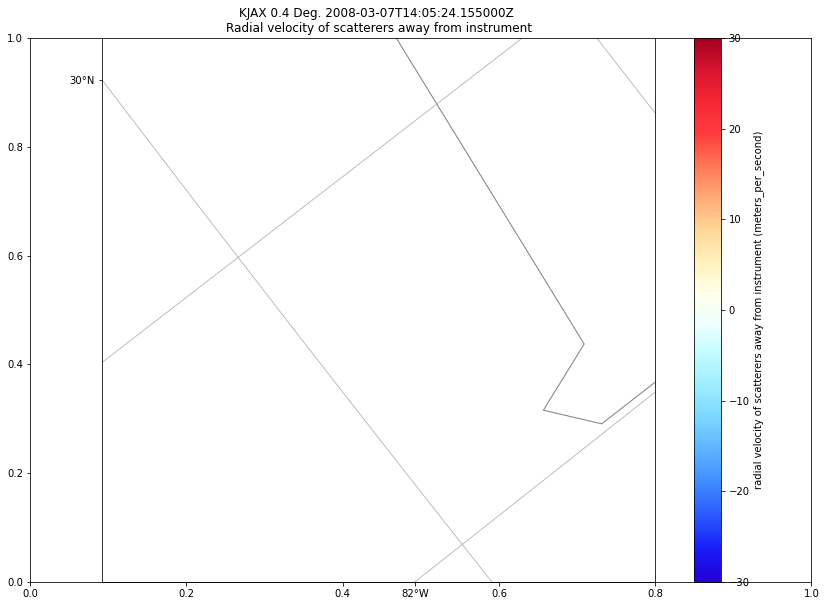

In [8]:
myf = plt.figure(figsize=[14,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('velocity', 1, vmin=-30, vmax=30, resolution= '110m',\
                 min_lat=wid500.slat[icase]-0.5, max_lat=wid500.slat[icase]+0.5,\
                 min_lon=wid500.slon[icase]-0.5, max_lon=wid500.slon[icase]+0.5 )

# Looping and plotting 

Station: KSRX
Distance from radar(km) 46.38654164730245
KSRX20160324_030056_V06.gz  downloading to 
Downloaded KSRX20160324_030056_V06.gz
1 out of 1 files downloaded...0 errors
/Users/poopiebuttcheeks/Box/MapesGroupUndergradResearch/NEXRAD_FILES/KSRX20160324_030056_V06.gz


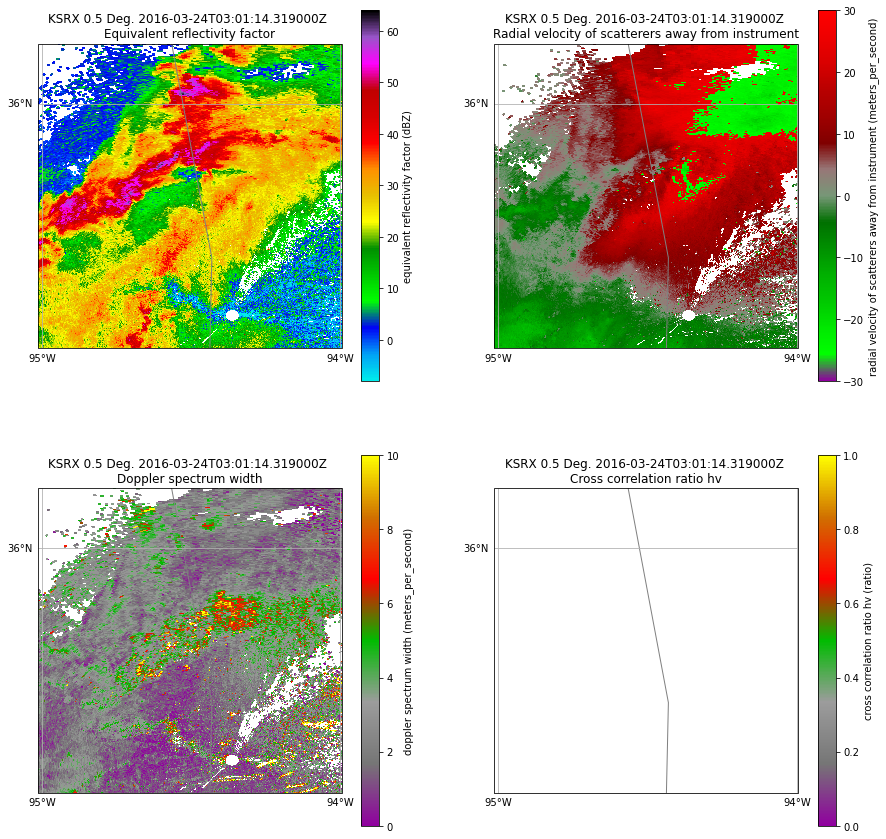

In [16]:
#loop through data, ignoring empty scans

#1000 - 1025
# PDF 
# 
for icase in range(300,301):
        
        station = wid500['NearestRadar'][icase]
        print("Station:", station)
        distance = wid500['NearestDist'][icase]
        print("Distance from radar(km)", distance)
        
        #### Where to download the data into: our Box #### 
        data_dir = os.path.expanduser('~/Box/MapesGroupUndergradResearch/NEXRAD_FILES')

        #### Connect to Amazon ####
        conn = nexradaws.NexradAwsInterface()

        # List all scans within 1 hour of the case hour 
        # conn.get_avail_scans_in_range(start, end, radar)
       
    
        ####hour and minute formate correction####
        
        txt= wid500['time'][icase][0:2]
        digits = [txt[i] for i in range(len(txt)) if txt[i].isdigit()]
        hour = int(''.join(digits))
        
        txt= wid500['time'][icase][3:5]
        digits = [txt[i] for i in range(len(txt)) if txt[i].isdigit()]
        minute = int(''.join(digits))
        
        ######Convert to datetime---->Central time+6 hours#######
        
        #d = datetime.datetime(wid500['yr'][icase], wid500['mo'][icase], wid500['dy'][icase],hour)
        d_min = datetime.datetime(wid500['yr'][icase], wid500['mo'][icase], wid500['dy'][icase],hour,minute)
        dcent = d_min+datetime.timedelta(hours=6) #UTC to Central time conversion
        d2 = dcent + datetime.timedelta(hours=1)
       
        #### Try and obtain avalaib le scan sweeps. If data is empty, ignore ####
        try:
            scans = conn.get_avail_scans_in_range(dcent, d2, wid500['NearestRadar'][icase])
        except:
            print('ignore error')

        # next to last sweep in the hour [-2]
        # must avoid filenames not ending in _V06
        # so more code needed here, but this works for icase=1
        try:
            print(scans[1].filename, ' downloading to ')
        except:
            print('ignore error')
        
        try:
            localfiles = conn.download(scans[1],data_dir)
        except:
            print('ignore error')
        
        print(localfiles.success[0].filepath)
        
        #
        for suc in localfiles.success:
            fname = (suc.filepath) #/Users/poopiebuttcheeks/Box/MapesGroupUndergradResearch/NEXRAD_FILES/KJAX20080307_140507.gz
            Datestring = fname[73:88]
            d_avail= datetime.datetime.strptime(Datestring, "%Y%m%d_%H%M%S")
            
        
    
    
    
    #### Plotting ####
        radar = pyart.io.read(localfiles.success[0].filepath)

        display = pyart.graph.RadarMapDisplay(radar)

        projection = ccrs.PlateCarree()


          

        fig = plt.figure(figsize=[15,15])


        ax1 = plt.subplot(221,projection=ccrs.PlateCarree())

        display.plot_ppi_map('reflectivity', 1, vmin=-8, vmax=64, resolution = '110m',\
                             min_lat=wid500.slat[icase]-0.51, max_lat=wid500.slat[icase]+0.51,\
                             min_lon=wid500.slon[icase]-0.51, max_lon=wid500.slon[icase]+0.51,\
                             edges=False,mask_outside = False,cmap = pyart.graph.cm.NWSRef,ax = ax1,projection=ccrs.PlateCarree())


        ax1.arrow(wid500.slat[icase],wid500.slon[icase], wid500.elat[icase], wid500.elon[icase], width=1) 

        ax2 = plt.subplot(222,projection=ccrs.PlateCarree())



        display.plot_ppi_map('velocity', 1, vmin=-30, vmax=30, resolution= '110m',\
                             min_lat=wid500.slat[icase]-0.51, max_lat=wid500.slat[icase]+0.51,\
                             min_lon=wid500.slon[icase]-0.51, max_lon=wid500.slon[icase]+0.51,\
                             cmap = pyart.graph.cm.NWSVel,ax = ax2,projection=ccrs.PlateCarree())
        
        ax3 = plt.subplot(223,projection=ccrs.PlateCarree())

        display.plot_ppi_map('spectrum_width', 1,vmin = 0, vmax = 10, resolution = '110m',\
                             min_lat=wid500.slat[icase]-0.51, max_lat=wid500.slat[icase]+0.51,\
                             min_lon=wid500.slon[icase]-0.51, max_lon=wid500.slon[icase]+0.51,\
                             cmap = pyart.graph.cm.NWS_SPW,edges=False,mask_outside = False,ax = ax3,projection=ccrs.PlateCarree())
        try:
            ax4 = plt.subplot(224,projection=ccrs.PlateCarree())

            display.plot_ppi_map('cross_correlation_ratio', 1,vmin = 0, vmax = 1, resolution = '110m',\
                             min_lat=wid500.slat[icase]-0.51, max_lat=wid500.slat[icase]+0.51,\
                             min_lon=wid500.slon[icase]-0.51, max_lon=wid500.slon[icase]+0.51,\
                             cmap = pyart.graph.cm.NWS_SPW,edges=False,mask_outside = False,ax = ax4,projection=ccrs.PlateCarree())
        except:
            print("No Data")

        
        
        
        
        
        
        
        
        
        

In [19]:
radar.fields


{'velocity': {'units': 'meters_per_second',
  'standard_name': 'radial_velocity_of_scatterers_away_from_instrument',
  'long_name': 'Mean doppler Velocity',
  'valid_max': 95.0,
  'valid_min': -95.0,
  'coordinates': 'elevation azimuth range',
  '_FillValue': -9999.0,
  'data': masked_array(
    data=[[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [-8.5, -9.0, -10.0, ..., --, --, --],
          [-8.5, -11.0, -10.5, ..., --, --, --],
          [-8.0, -10.5, -10.5, ..., --, --, --]],
    mask=[[ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          ...,
          [False, False, False, ...,  True,  True,  True],
          [False, False, False, ...,  True,  True,  True],
          [False, False, False, ...,  True,  True,  True]],
    fill_value=1e+20,
    dtype=float32)},
 'reflect

In [ ]:
#loop through data, ignoring empty scans

#1000 - 1025

for icase in range(951,952):
        
        station = wid500['NearestRadar'][icase]
        print("Station:", station)
        distance = wid500['NearestDist'][icase]
        print("Distance from radar(km)", distance)
        
        #### Where to download the data into: our Box #### 
        data_dir = os.path.expanduser('~/Box/MapesGroupUndergradResearch/NEXRAD_FILES')

        #### Connect to Amazon ####
        conn = nexradaws.NexradAwsInterface()

        # List all scans within 1 hour of the case hour 
        # conn.get_avail_scans_in_range(start, end, radar)
       
    
        ####hour and minute formate correction####
        
        txt= wid500['time'][icase][0:2]
        digits = [txt[i] for i in range(len(txt)) if txt[i].isdigit()]
        hour = int(''.join(digits))
        
        txt= wid500['time'][icase][3:5]
        digits = [txt[i] for i in range(len(txt)) if txt[i].isdigit()]
        minute = int(''.join(digits))
        
        ######Convert to datetime---->Central time+6 hours#######
        
        #d = datetime.datetime(wid500['yr'][icase], wid500['mo'][icase], wid500['dy'][icase],hour)
        d_min = datetime.datetime(wid500['yr'][icase], wid500['mo'][icase], wid500['dy'][icase],hour,minute)
        dcent = d_min+datetime.timedelta(hours=6) #UTC to Central time conversion
        d2 = dcent + datetime.timedelta(hours=1)
       
        #### Try and obtain avalaib le scan sweeps. If data is empty, ignore ####
        try:
            scans = conn.get_avail_scans_in_range(dcent, d2, wid500['NearestRadar'][icase])
        except:
            print('ignore error')

        # next to last sweep in the hour [-2]
        # must avoid filenames not ending in _V06
        # so more code needed here, but this works for icase=1
        try:
            print(scans[1].filename, ' downloading to ')
        except:
            print('ignore error')
        
        try:
            localfiles = conn.download(scans[1],data_dir)
        except:
            print('ignore error')
        
        print(localfiles.success[0].filepath)
        
        #
        for suc in localfiles.success:
            fname = (suc.filepath) #/Users/poopiebuttcheeks/Box/MapesGroupUndergradResearch/NEXRAD_FILES/KJAX20080307_140507.gz
            Datestring = fname[73:88]
            d_avail= datetime.datetime.strptime(Datestring, "%Y%m%d_%H%M%S")
            
        
    
    #### Plotting ####
        radar = pyart.io.read(localfiles.success[0].filepath)
        
        myf = plt.figure(figsize=[14,10])
        myd = pyart.graph.RadarMapDisplay(radar)
        myd.plot_ppi_map('reflectivity', 1, vmin=-8, vmax=64, resolution = '110m',\
                 min_lat=wid500.slat[icase]-0.5, max_lat=wid500.slat[icase]+0.5,\
                 min_lon=wid500.slon[icase]-0.5, max_lon=wid500.slon[icase]+0.5 )
       

        myf = plt.figure(figsize=[14,10])
        myf.patch.set_visible(False)
        myd = pyart.graph.RadarMapDisplay(radar)
        myd.plot_ppi_map('velocity', 1, vmin=-30, vmax=30, resolution= '110m',\
                 min_lat=wid500.slat[icase]-0.5, max_lat=wid500.slat[icase]+0.5,\
                 min_lon=wid500.slon[icase]-0.5, max_lon=wid500.slon[icase]+0.5 )